In [ ]:
#pip install pandasql

In [ ]:
#pip install holidays

In [ ]:
#pip install prophet

In [2]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=4e22092590c204d6b9719b2e0949d92d046dfc80535650dbe5f1e1f6c2eaf205
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [2]:
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 20-25 Sales .csv to 20-25 Sales  (2).csv


In [4]:
# Load Data
file_path = "20-25 Sales .csv"
df = pd.read_csv(file_path)

df.head()

,Date,Sales
0,7/20/20,0
1,8/1/20,11
2,9/1/20,31
3,10/1/20,46
4,11/1/20,31


In [5]:
#Exclude rows that contain 0 sales
df = df[df['Sales']!=0]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 1 to 54
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    54 non-null     object
 1   Sales   54 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


In [7]:
# Change the ds column to datetime for prophet
df['Date']=pd.to_datetime(df['Date'])
df.dtypes

<ipython-input-7-8bdfbdbb63f7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])


,0
Date,datetime64[ns]
Sales,int64


In [8]:
# Find the minimum and maximum date
min(df['Date']), max(df['Date'])

(Timestamp('2020-08-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))

In [49]:
#Adding holiday data

holiday = pd.DataFrame([])

us_holidays = holidays.US()

us_holidays = holidays.country_holidays('US')


for date_, name in sorted(holidays.US(years=[2023.2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "US-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['Date'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

<ipython-input-49-e95035a7662c>:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['Date'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window,Date
0,2023-01-01,US-Holidays,-2,1,2023-01-01
1,2023-01-02,US-Holidays,-2,1,2023-01-02
2,2023-01-16,US-Holidays,-2,1,2023-01-16
3,2023-02-20,US-Holidays,-2,1,2023-02-20
4,2023-05-29,US-Holidays,-2,1,2023-05-29


In [50]:
# Rename a single column
df.rename(columns={'Date': 'ds','Sales': 'y'}, inplace=True)

In [51]:
#Visualize the change in ds column
df.head()

,ds,y
1,2020-08-01,11
2,2020-09-01,31
3,2020-10-01,46
4,2020-11-01,31
5,2020-12-01,38


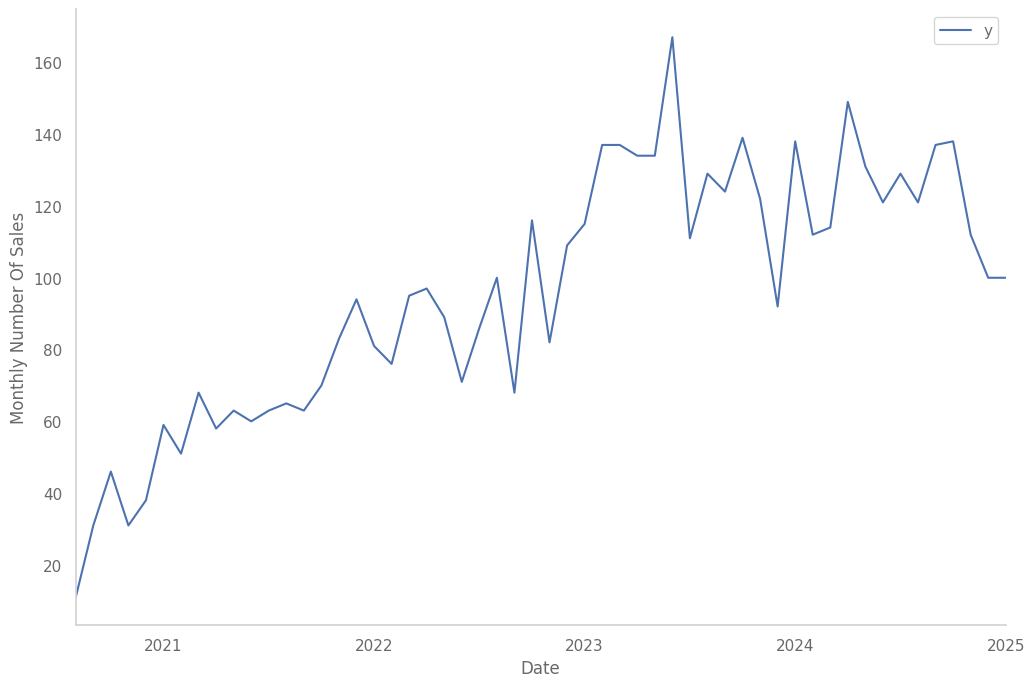

In [52]:
# Visualize the data
ax=df.set_index('ds').plot(figsize=(12,8))
ax.set_ylabel('Monthly Number Of Sales')
ax.set_xlabel('Date')
plt.show()

In [53]:
#Set the uncertainty interval to 95%. (defalut is 80%)
my_model = Prophet(interval_width=0.95, holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True)


In [54]:
#Call the fit method with our Dataframe as the input
my_model.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 42.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0krk2zk/tvhnw5c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0krk2zk/zt5ubjgz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30749', 'data', 'file=/tmp/tmpy0krk2zk/tvhnw5c2.json', 'init=/tmp/tmpy0krk2zk/zt5ubjgz.json', 'output', 'file=/tmp/tmpy0krk2zk/prophet_modelsd53hy04/prophet_model-20250228022920.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
# Allow prophet to create a new dataframe with a ds column that will hold the date for which we want predictions
#periods= is the number of datestamps we want for the future forecasting, freq indicates months, days, weeks. MS=month
future_dates = my_model.make_future_dataframe(periods=12, freq="MS")
future_dates.tail()

,ds
61,2025-09-01
62,2025-10-01
63,2025-11-01
64,2025-12-01
65,2026-01-01


In [56]:
# Forecast for the future dates and
forecast = my_model.predict(future_dates)
# This narrows down the columns that are present for the prediction model
forecast[['ds','yhat','yhat_lower','yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,21.85,0.94,43.16
1,2020-09-01,33.16,11.73,55.46
2,2020-10-01,46.90,25.51,68.73
3,2020-11-01,30.32,9.54,50.96
4,2020-12-01,37.21,14.84,57.85
5,2021-01-01,42.22,20.54,65.17
6,2021-02-01,60.06,38.83,80.97
7,2021-03-01,65.47,45.58,85.53
8,2021-04-01,68.05,47.58,88.11
9,2021-05-01,64.85,42.14,86.30


In [76]:
# copy df Merge the original data with the predicted data
df = df.copy()
df.columns = ['ds','y']
forecast = forecast.merge(df)

In [77]:
#Merge the data with the original data and choose the columns to show
forecast[['ds','y','yhat','yhat_lower','yhat_upper']]

,ds,y,yhat,yhat_lower,yhat_upper
0,2020-08-01,11,21.85,0.94,43.16
1,2020-09-01,31,33.16,11.73,55.46
2,2020-10-01,46,46.90,25.51,68.73
3,2020-11-01,31,30.32,9.54,50.96
4,2020-12-01,38,37.21,14.84,57.85
5,2021-01-01,59,42.22,20.54,65.17
6,2021-02-01,51,60.06,38.83,80.97
7,2021-03-01,68,65.47,45.58,85.53
8,2021-04-01,58,68.05,47.58,88.11
9,2021-05-01,63,64.85,42.14,86.30


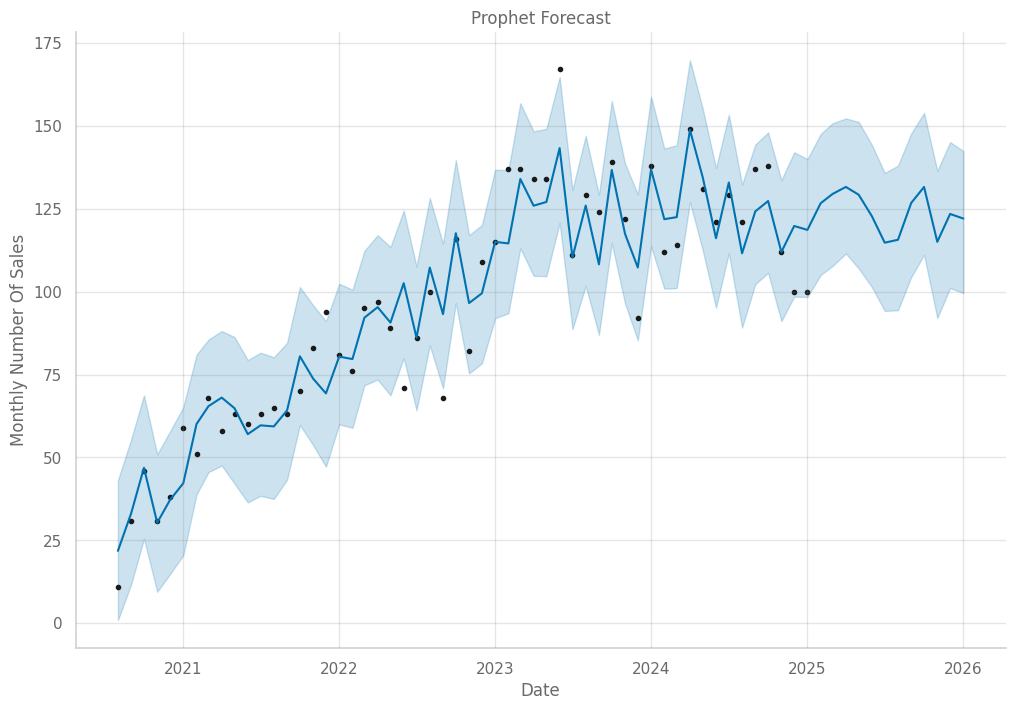

In [57]:
#Plot the forecasted model. The black dots are the actual values and the blue represents the forecasted values from the model.
#Shaded reason is area of uncertainty.
fig, ax=plt.subplots(figsize=(12,8))
my_model.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
ax.set_ylabel('Monthly Number Of Sales')
ax.set_xlabel('Date')
plt.show()

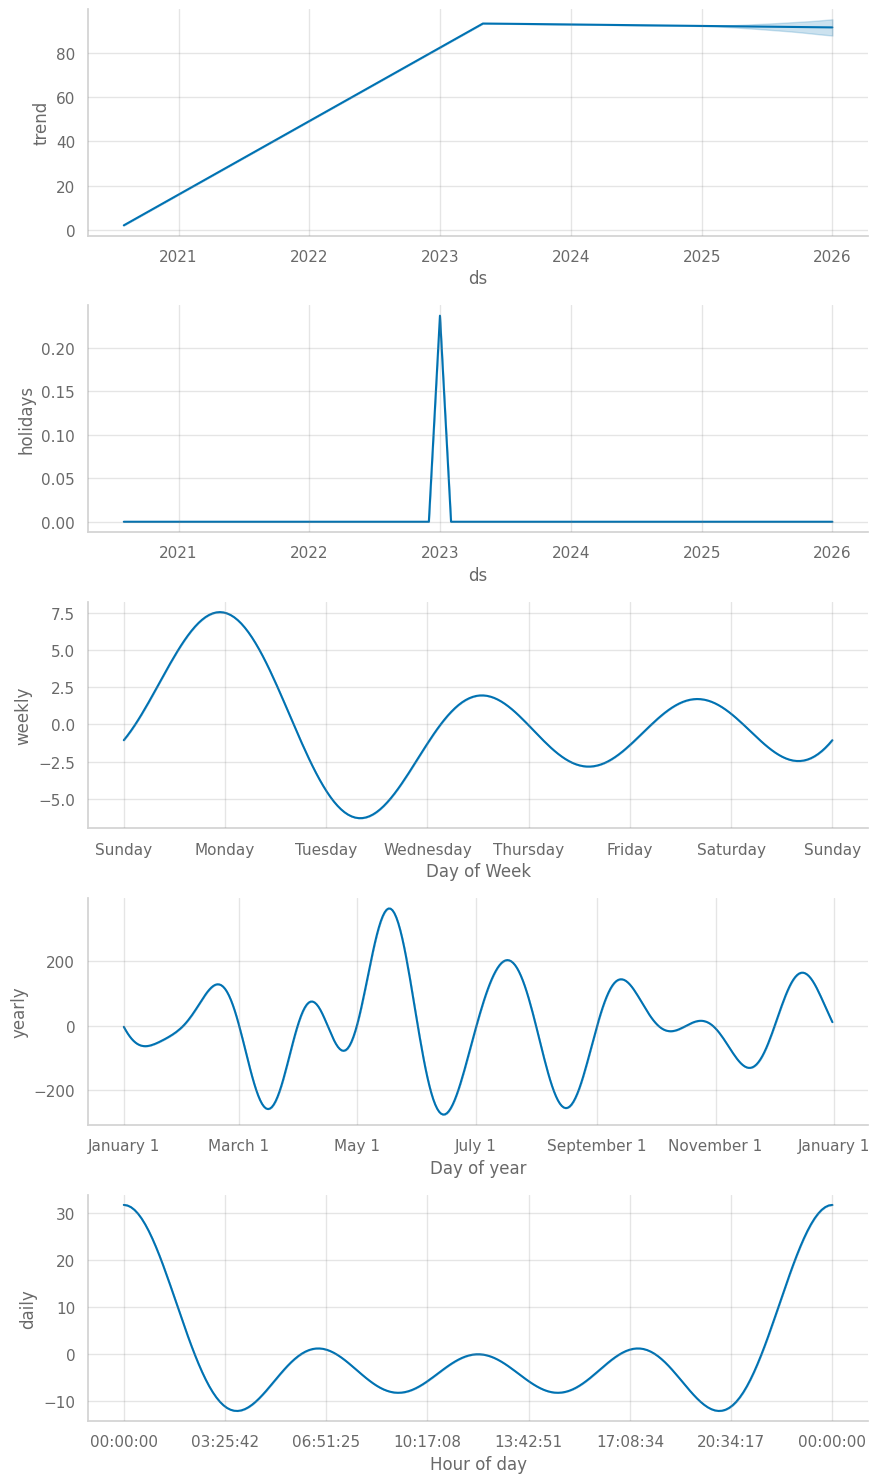

In [58]:
#Plot the components of the forecast
fig1 = my_model.plot_components(forecast)
plt.show()

In [59]:
mape(df['y'],forecast['yhat'][:len(df)])

10.30053744973906

Perform a test/train split cutting off the last year of the data

In [60]:
#Train/Test split cutting off the last year of data
split_date = pd.to_datetime('2023-01-01')
train = df[df['ds'] <= split_date]
test = df[df['ds'] > split_date]

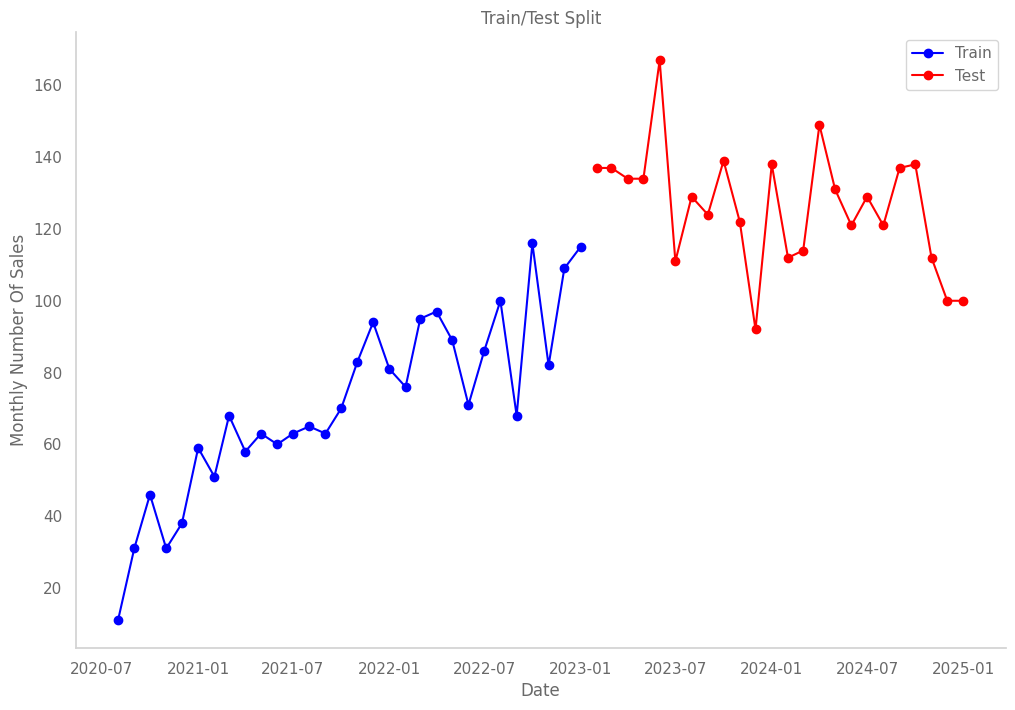

In [61]:
plt.figure(figsize=(12,8))
plt.plot(train['ds'], train['y'], label="Train", color ='blue', marker='o')
plt.plot(test['ds'], test['y'], label="Test", color ='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Monthly Number Of Sales')
plt.title('Train/Test Split')
plt.legend()
plt.show()

In [62]:
#Prepare data for new prohet model
df_train_prophet=train.copy()
df_train_prophet.columns = ['ds','y']
df_test_prophet = test.copy()
df_test_prophet.columns = ['ds','y']
df_train_prophet.head()

,ds,y
1,2020-08-01,11
2,2020-09-01,31
3,2020-10-01,46
4,2020-11-01,31
5,2020-12-01,38


In [63]:
#Fit the model with the training data
model_split = Prophet(interval_width=0.95,holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True)
model_split.fit(df_train_prophet)

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0krk2zk/rhgzrlxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0krk2zk/wxpc1z5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87533', 'data', 'file=/tmp/tmpy0krk2zk/rhgzrlxo.json', 'init=/tmp/tmpy0krk2zk/wxpc1z5l.json', 'output', 'file=/tmp/tmpy0krk2zk/prophet_modelbj_7r7vy/prophet_model-20250228023144.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [64]:
 #Generate future dataframe for predictions
 df_test_forecast = model_df.predict(df_test_prophet)

In [65]:
# Show the predictions
df_test_forecast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2023-02-01,109.44,97.57,120.95
1,2023-03-01,126.75,114.90,138.88
2,2023-04-01,150.86,138.76,162.92
3,2023-05-01,117.66,104.60,129.78
4,2023-06-01,75.26,63.60,87.42
5,2023-07-01,108.36,96.02,121.94
6,2023-08-01,168.08,156.46,180.59
7,2023-09-01,76.36,63.85,88.35
8,2023-10-01,156.46,144.51,168.14
9,2023-11-01,103.13,92.03,115.88


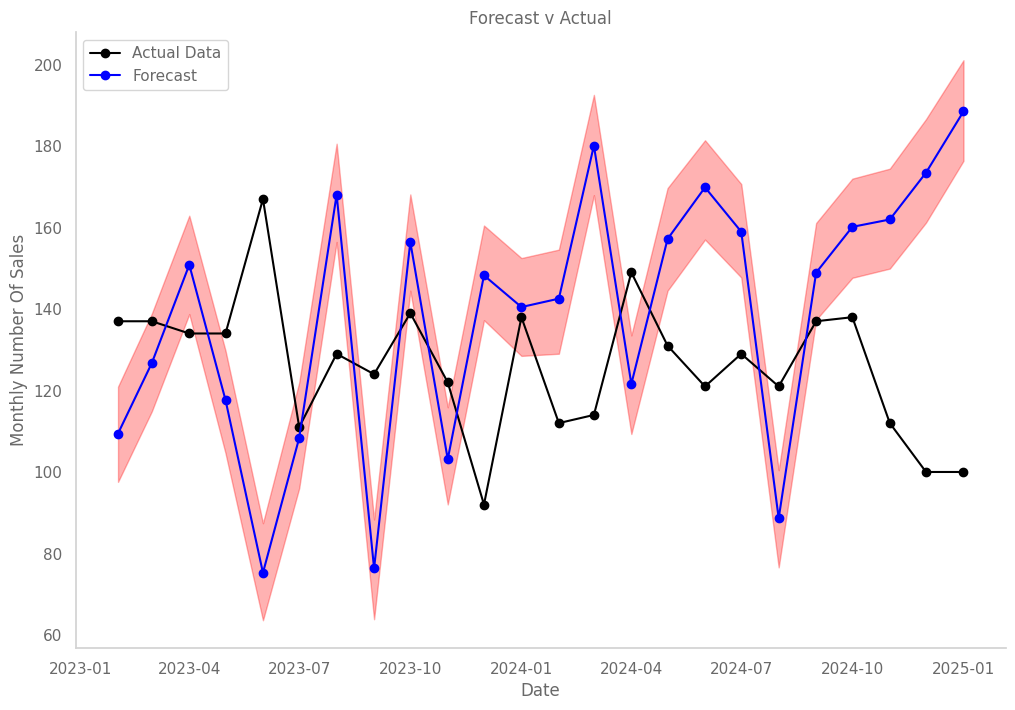

In [66]:
# Compare the actual data to the predicted data in graph
plt.figure(figsize=(12,8))
plt.plot(test['ds'], test['y'], label="Actual Data", color ='black', marker='o')
plt.plot(df_test_forecast['ds'], df_test_forecast['yhat'], label="Forecast", color ='blue', marker='o')
plt.fill_between(df_test_forecast['ds'], df_test_forecast['yhat_lower'], df_test_forecast['yhat_upper'], color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Monthly Number Of Sales')
plt.title('Forecast v Actual')
plt.legend()
plt.show()


In [67]:
# Calculate the mape (Mean Absolute Percentage Error)
mape(test['y'], df_test_forecast['yhat'])

29.7853434822673

Prediction Model Taking into account Holidays

In [68]:
forecast_holidays = my_model.predict(future_dates,holidays)
forecast_holidays[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,21.85,0.22,42.77
1,2020-09-01,33.16,12.74,55.11
2,2020-10-01,46.90,24.51,68.23
3,2020-11-01,30.32,8.51,52.09
4,2020-12-01,37.21,15.28,60.76
5,2021-01-01,42.22,20.83,64.79
6,2021-02-01,60.06,38.21,81.57
7,2021-03-01,65.47,44.09,86.71
8,2021-04-01,68.05,46.26,88.96
9,2021-05-01,64.85,43.38,86.27


In [69]:
# copy df Merge the original data with the predicted data
df = df.copy()
df.columns = ['ds','y']
forecast_holidays = forecast_holidays.merge(df)

In [70]:
#Merge the data with the original data and choose the columns to show
forecast_holidays[['ds','y','yhat','yhat_lower','yhat_upper']]

,ds,y,yhat,yhat_lower,yhat_upper
0,2020-08-01,11,21.85,0.22,42.77
1,2020-09-01,31,33.16,12.74,55.11
2,2020-10-01,46,46.90,24.51,68.23
3,2020-11-01,31,30.32,8.51,52.09
4,2020-12-01,38,37.21,15.28,60.76
5,2021-01-01,59,42.22,20.83,64.79
6,2021-02-01,51,60.06,38.21,81.57
7,2021-03-01,68,65.47,44.09,86.71
8,2021-04-01,58,68.05,46.26,88.96
9,2021-05-01,63,64.85,43.38,86.27


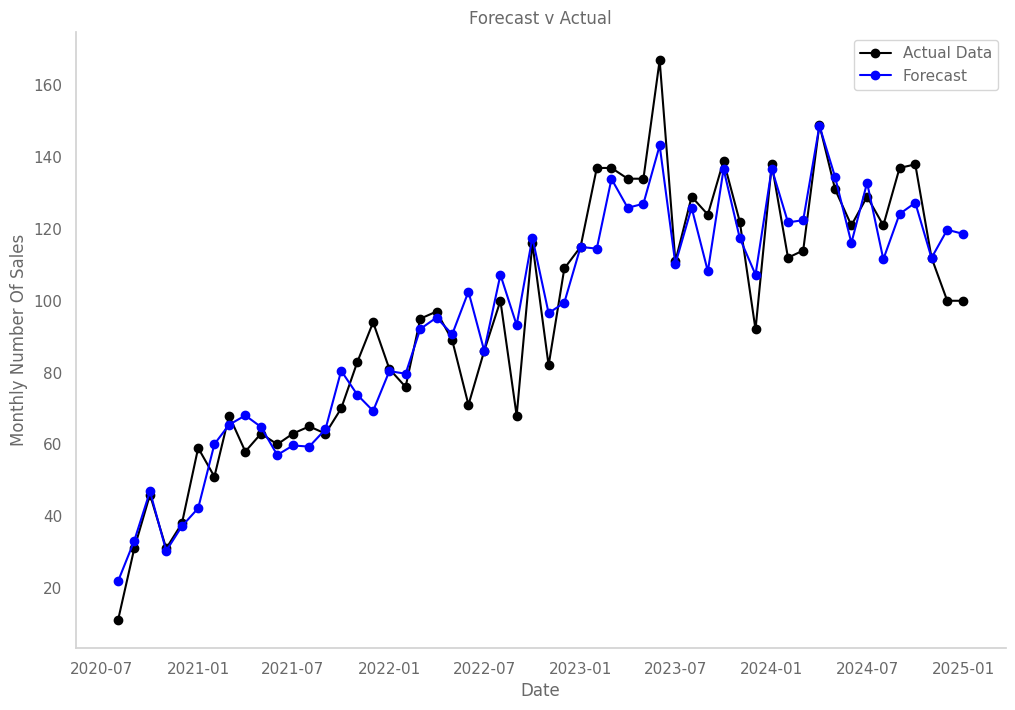

In [71]:
# Plot the merged data
merged = pd.concat([df['y'],forecast_holidays['yhat']],axis=1)
plt.figure(figsize=(12,8))
plt.plot(df['ds'], df['y'], label="Actual Data", color ='black', marker='o')
plt.plot(forecast_holidays['ds'], forecast_holidays['yhat'], label="Forecast", color ='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Monthly Number Of Sales')

plt.title('Forecast v Actual')
plt.legend()
plt.show()

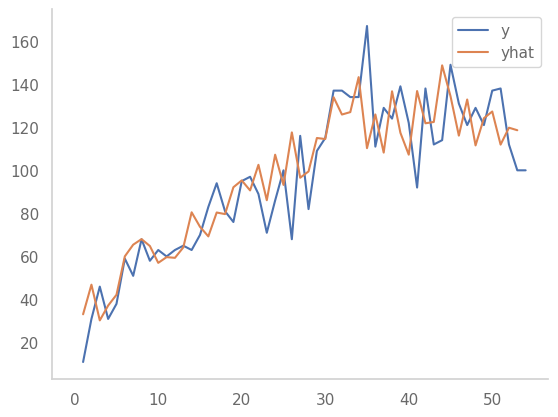

In [72]:
# Basic plot of the merged data
pd.concat([df['y'],forecast_holidays['yhat']],axis=1).plot();

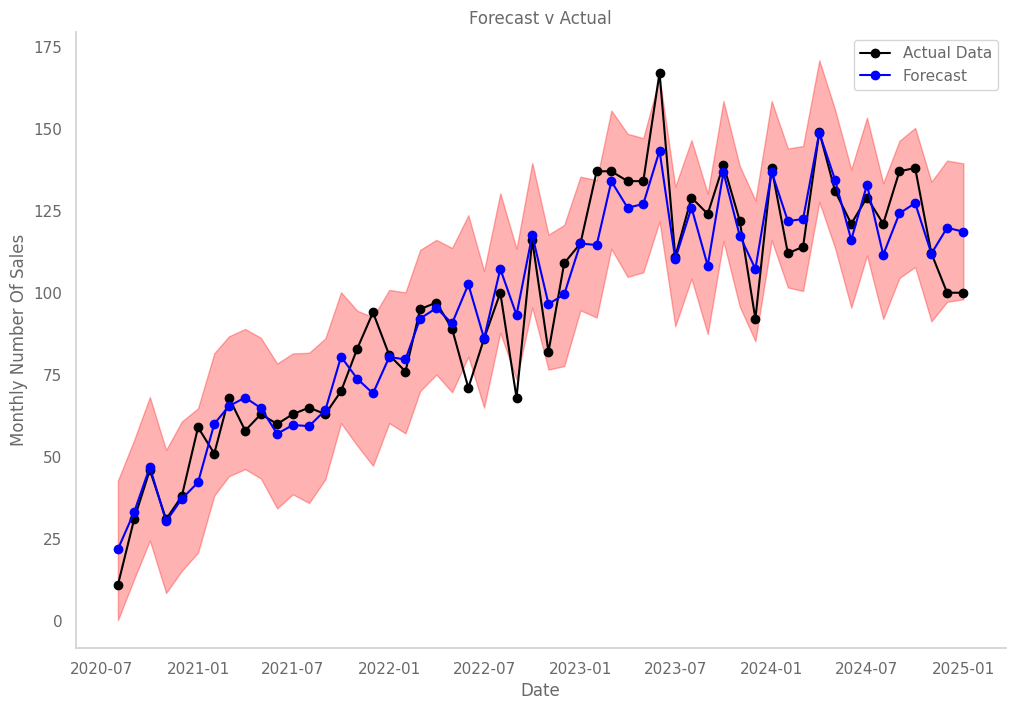

In [73]:
plt.figure(figsize=(12,8))
plt.plot(df['ds'], df['y'], label="Actual Data", color ='black', marker='o')
plt.plot(forecast_holidays['ds'], forecast_holidays['yhat'], label="Forecast", color ='blue', marker='o')
plt.fill_between(forecast_holidays['ds'], forecast_holidays['yhat_lower'], forecast_holidays['yhat_upper'], color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Monthly Number Of Sales')
plt.title('Forecast v Actual')
plt.legend()
plt.show()

In [74]:
#Calculate the MAPE for the forecast model taking into account Holidays
mape(df['y'], forecast_holidays['yhat'])

10.30053744973906

Extra Plots

In [49]:
# Interactive plot of forecast data
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(my_model, forecast)

In [48]:
plot_components_plotly(my_model, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.

